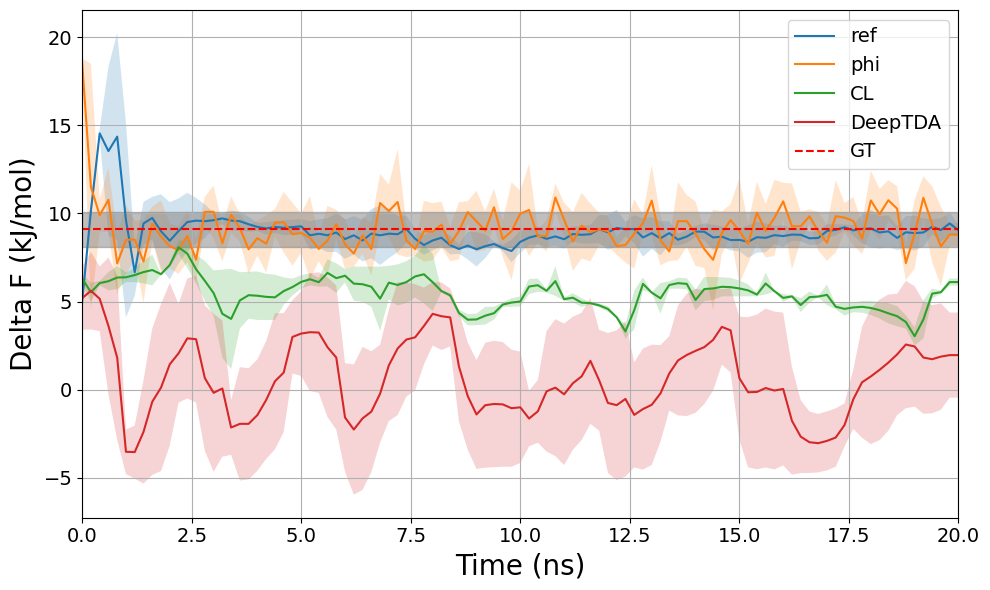

In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d


def calculate_delta_f(phi, free):    
    # Filter data based on conditions
    A = free[phi < 0]
    B = free[(phi > 0) & (phi < 2.2)]
    
    # Calculate free energies
    fesA = -2.49 * np.logaddexp.reduce(-1 / 2.49 * A)
    fesB = -2.49 * np.logaddexp.reduce(-1 / 2.49 * B)
    return fesB - fesA

def load_data(fes_dir, method, i):
    fes_file = os.path.join(fes_dir, 'fes', str(i)+".dat")

    # Load data from the file
    data = np.loadtxt(fes_file, comments='#')
    
    with open(fes_file, 'r') as file:
        first_line = file.readline().strip()
        
    keys = first_line.split()[2:]
    phi_idx = keys.index(cv_name[method])
    free_idx = keys.index('file.free')

    phi = data[:, phi_idx]
    free = data[:, free_idx]
    return phi, free

def load_interp(fes_dir, method, i):
    fes_file = os.path.join(fes_dir, 'fes', str(i)+".dat")
    cv_file = os.path.join(fes_dir, "COLVAR")

    # Load data from the file
    data = np.loadtxt(fes_file, comments='#')
    
    with open(fes_file, 'r') as file:
        first_line = file.readline().strip()
        
    keys = first_line.split()[2:]
    cv_idx = keys.index(cv_name[method])
    free_idx = keys.index('file.free')

    cv_grid = data[:, cv_idx]
    free_grid = data[:, free_idx]

    # Load data from the file
    data = np.loadtxt(cv_file, comments='#')
    
    with open(cv_file, 'r') as file:
        first_line = file.readline().strip()
        
    keys = first_line.split()[2:]
    cv_idx = keys.index(cv_name[method])
    phi_idx = keys.index('phi')

    cv = data[:, cv_idx]
    phi = data[:, phi_idx]

    # 선형 보간: deep_cv 범위 밖이면 extrapolate
    fes_interp = interp1d(
        cv_grid, 
        free_grid, 
        kind='linear', 
        fill_value="extrapolate"
    )

    free = fes_interp(cv)
    return phi, free
    
def plot(methods, dates, base_dir):
    plt.figure(figsize=(10, 6))
    times = np.linspace(0,20,101)
    for method,date in zip(methods,dates):
        seed_delta_fs = []
        for seed in range(4):
            delta_fs = []
            for i in range(101):
                fes_dir = os.path.join(base_dir, method, 'log', date, str(seed))
                if method in ['phi','ref']:
                    phi, free = load_data(fes_dir, method, i)
                else:
                    phi, free = load_interp(fes_dir, method, i)
                delta_f = calculate_delta_f(phi, free)
                delta_fs.append(delta_f)
            
            if np.any(np.isinf(delta_fs)):
                continue

            seed_delta_fs.append(delta_fs)

        delta_fs = np.array(seed_delta_fs)
        mean_delta_fs = np.mean(seed_delta_fs, axis=0)
        std_delta_fs = np.std(seed_delta_fs, axis=0)
        
        
        plt.plot(times, mean_delta_fs, label=f'{method}')
        plt.fill_between(times, mean_delta_fs - std_delta_fs, mean_delta_fs + std_delta_fs, alpha=0.2)

    plt.xlim(0,20)
    plt.axhline(y=9.1, color='r', linestyle='--', label='GT')
    plt.fill_between(times, 9.1 - 1, 9.1 + 1, color='gray', alpha=0.5)
    plt.xlabel('Time (ns)', fontsize=20, fontweight="medium")
    plt.ylabel('Delta F (kJ/mol)', fontsize=20, fontweight="medium")
    plt.legend(fontsize=14)
    plt.xticks(fontsize=14)
    plt.yticks(fontsize=14)
    plt.grid(True)
    plt.tight_layout()
    plt.savefig('../figures/time_delta_fs.png', dpi=300, bbox_inches="tight")
    plt.savefig('../figures/time_delta_fs.pdf', dpi=300, bbox_inches="tight")
    plt.show()

cv_name = {
    'phi': 'phi',
    'ref': 'phi',
    'CL': 'deep.node-2',
    'DeepTDA': 'deep.node-0',
}


# method = 'phi'
# date = '0120114455'
# method = 'ref'
# date = '0120114606'
method = 'CL'
date = '0120120020'
# method = 'DeepTDA'
# date = '0120120139'

methods = ['ref','phi', 'CL', 'DeepTDA']
dates = ['0120114606', '0120114455','0120120020','0120120139']
base_dir = '/home/guest_sky/geodesic-interpolation-cv/simulations/aldp/'

plot(methods, dates, base_dir)